<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-Projects/blob/main/Intermediate/PyTorch-FineGrained-TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Grained Transfer Learning

In [ ]:
!pip install torchmetrics

In [ ]:
import torch
from torch import nn
import torchvision as tv
import torchmetrics as tm
from torchvision import transforms
from torchvision.datasets import Flowers102
from torch.utils.data import Dataset, DataLoader

import math
import random
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Configuration

In [ ]:
conf_dict = {
    # Reproducibility
    "seed": 42,

    # Computing Device
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    # Data Settings
    "root_dir": "./data",
    "image_size": 224,
    "batch_size": 32,
    "num_workers": 2,
    "pin_memory": True,

    # Model Settings
    "architecture": "resnet18",   # Backbone Architecture
    "pretrained": True,
    "num_classes": 102,

    # Training Hyperparameters
    "epochs": 25,
    "lr_head": 1e-3,              # LR for classifier head
    "lr_backbone": 1e-4,          # Lower LR for fine-tuning backbone
    "weight_decay": 1e-4,
    "label_smoothing": 0.0,

    # Scheduler
    "scheduler": "onecycle",

    # Imbalance Handling
    "use_class_weights": True,
    "use_weighted_sampler": False,

    # Logging & Saving
    "log_every_n_steps": 20,
    "save_best_by": "val_loss",
    "checkpoint_dir": "No checkpoints for now"
}

print(conf_dict)

{'seed': 42, 'device': 'cuda', 'root_dir': './data', 'image_size': 224, 'batch_size': 32, 'num_workers': 2, 'pin_memory': True, 'architecture': 'resnet50', 'pretrained': True, 'num_classes': 102, 'epochs': 25, 'lr_head': 0.001, 'lr_backbone': 0.0001, 'weight_decay': 0.0001, 'label_smoothing': 0.0, 'scheduler': 'onecycle', 'use_class_weights': True, 'use_weighted_sampler': False, 'log_every_n_steps': 20, 'save_best_by': 'val_loss', 'checkpoint_dir': 'No checkpoints for now'}


In [ ]:
device = conf_dict["device"]

In [ ]:
# Set seed for reproducibility
SEED = conf_dict["seed"]

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior
## for speed over strict determinism, set deterministic=False and benchmark=True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data Transforms

In [ ]:
# Normalization values (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Traning Transforms (Augmentaion + Normalization)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = mean, std = std
    )
])

# Validation & Test Transforms (No heavy augmentation, just resize and center)
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = mean, std = std
    )
])

test_transforms = val_transforms

# Load Data

In [ ]:
# Load Datasets
train_dataset = Flowers102(root=conf_dict["root_dir"], split="train", transform=train_transforms, download=True)
val_dataset = Flowers102(root=conf_dict["root_dir"], split="val", transform=val_transforms, download=True)
test_dataset = Flowers102(root=conf_dict["root_dir"], split="test", transform=test_transforms, download=True)

In [ ]:
# Define Default DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size = conf_dict["batch_size"], shuffle = True,
    num_workers = conf_dict["num_workers"], pin_memory = conf_dict["pin_memory"]
)

val_loader = DataLoader(
    val_dataset, batch_size = conf_dict["batch_size"], shuffle = False,
    num_workers = conf_dict["num_workers"], pin_memory = conf_dict["pin_memory"]
)

test_loader = DataLoader(
    test_dataset, batch_size = conf_dict["batch_size"], shuffle = False,
    num_workers = conf_dict["num_workers"], pin_memory = conf_dict["pin_memory"]
)

In [ ]:
# Check Class Imbalance

# Count samples per class in training set
targets = train_dataset._labels if hasattr(train_dataset, "_labels") else train_dataset.labels
class_counts = Counter(targets)
print("Class counts:", class_counts)

# Calculate weights: total_samples / (num_classes * count[class])
classes = train_dataset.classes
num_classes = len(classes)
total_samples = len(train_dataset)
class_weights = []

for c in range(num_classes):
  weight = total_samples / (num_classes * class_counts[c])
  class_weights.append(weight)

# Convert to tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss with weights
criterion = nn.CrossEntropyLoss(weight = class_weights)

Class counts: Counter({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 20: 10, 16: 10, 17: 10, 18: 10, 19: 10, 21: 10, 22: 10, 23: 10, 24: 10, 25: 10, 26: 10, 27: 10, 28: 10, 29: 10, 30: 10, 31: 10, 32: 10, 33: 10, 34: 10, 35: 10, 36: 10, 37: 10, 38: 10, 39: 10, 40: 10, 41: 10, 42: 10, 43: 10, 44: 10, 45: 10, 46: 10, 47: 10, 48: 10, 49: 10, 50: 10, 51: 10, 52: 10, 53: 10, 54: 10, 55: 10, 56: 10, 57: 10, 58: 10, 59: 10, 60: 10, 61: 10, 62: 10, 63: 10, 64: 10, 65: 10, 66: 10, 67: 10, 68: 10, 69: 10, 70: 10, 71: 10, 72: 10, 73: 10, 74: 10, 75: 10, 76: 10, 77: 10, 78: 10, 79: 10, 80: 10, 81: 10, 82: 10, 83: 10, 84: 10, 85: 10, 86: 10, 87: 10, 88: 10, 89: 10, 90: 10, 91: 10, 92: 10, 93: 10, 94: 10, 95: 10, 96: 10, 97: 10, 98: 10, 99: 10, 100: 10, 101: 10})


Class   0 | Count:   10 | Weight: 1.0000
Class   1 | Count:   10 | Weight: 1.0000
Class   2 | Count:   10 | Weight: 1.0000
Class   3 | Count:   10 | Weight: 1.0000
Class   4 | Count:   10 | Weight: 1.0000
Class   5 | Count:   10 | Weight: 1.0000
Class   6 | Count:   10 | Weight: 1.0000
Class   7 | Count:   10 | Weight: 1.0000
Class   8 | Count:   10 | Weight: 1.0000
Class   9 | Count:   10 | Weight: 1.0000


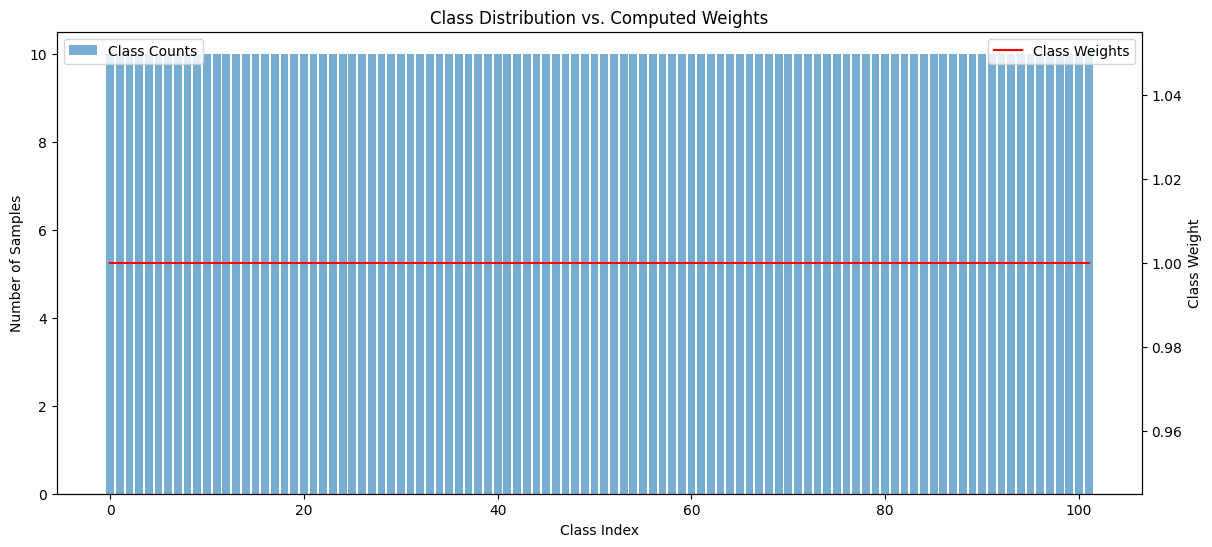

In [ ]:
# Plot distributions (counts vs weights)

# Convert counts into a list aligned with class indices
counts_list = [class_counts[c] for c in range(num_classes)]

# Print first 10 classes as a quick sanity check
for i in range(10):
    print(f"Class {i:3d} | Count: {counts_list[i]:4d} | Weight: {class_weights[i].item():.4f}")

fig, ax1 = plt.subplots(figsize=(14,6))

# Plot counts on left y-axis
ax1.bar(range(num_classes), counts_list, alpha=0.6, label="Class Counts")
ax1.set_xlabel("Class Index")
ax1.set_ylabel("Number of Samples")
ax1.legend(loc="upper left")

# Plot weights on right y-axis
ax2 = ax1.twinx()
ax2.plot(range(num_classes), class_weights.cpu().numpy(), 'r-', label="Class Weights")
ax2.set_ylabel("Class Weight")
ax2.legend(loc="upper right")

plt.title("Class Distribution vs. Computed Weights")
plt.show()

No class imabalance exists in the Flowers102 dataset.

# Classfier Head

## Model Definition

In [ ]:
# Load pretrained ResNet18
model = tv.models.resnet18(
    weights = tv.models.ResNet18_Weights.DEFAULT
)

# Freeze all model parameters
for params in model.parameters():
  params.requires_grad = False

# Get the number of input features to the final layer
in_features = model.fc.in_features

# Replace the final fc layer to match 102 classes
model.fc = nn.Linear(in_features, 102)

# Unfreeze only classifier parameters
for params in model.fc.parameters():
  params.requires_grad = True

model.to(device)

# Double-check which params will be trained
for name, param in model.named_parameters():
    if param.requires_grad:
        print("Trainable:", name)

Trainable: fc.weight
Trainable: fc.bias


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model Training

In [ ]:
# Define Optmizer
optimizer = torch.optim.Adam(
    model.fc.parameters(),
    lr = conf_dict["lr_head"],
    weight_decay = conf_dict["weight_decay"]
)

# Define Scheduler
steps_per_epoch = math.ceil(len(train_loader))

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr = conf_dict["lr_head"],
    steps_per_epoch = steps_per_epoch,
    epochs = conf_dict["epochs"]
)

In [ ]:
# Training Loop
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(conf_dict["epochs"]):

  # Training Phase
  model.train()
  epoch_train_loss = 0.0
  correct_train, total_train = 0, 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

    epoch_train_loss += loss.item()

    preds = torch.argmax(outputs, dim=1)
    correct_train += (preds == labels).sum().item()
    total_train += labels.size(0)

  epoch_train_loss /= len(train_loader)
  epoch_train_acc = correct_train / total_train
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_acc)

  # Validation Phase
  model.eval()
  epoch_val_loss = 0.0
  correct_val, total_val = 0, 0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      epoch_val_loss += loss.item()

      preds = torch.argmax(outputs, dim=1)
      correct_val += (preds == labels).sum().item()
      total_val += labels.size(0)

  epoch_val_loss /= len(val_loader)
  epoch_val_acc = correct_val / total_val
  val_loss.append(epoch_val_loss)
  val_acc.append(epoch_val_acc)

  print(f"Epoch [{epoch+1}/{conf_dict['epochs']}], "
          f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}"
  )

Epoch [1/25], Train Loss: 4.8283, Acc: 0.0137, Val Loss: 4.7332, Acc: 0.0098
Epoch [2/25], Train Loss: 4.6998, Acc: 0.0098, Val Loss: 4.5596, Acc: 0.0147
Epoch [3/25], Train Loss: 4.4955, Acc: 0.0333, Val Loss: 4.2904, Acc: 0.0588
Epoch [4/25], Train Loss: 4.2133, Acc: 0.0951, Val Loss: 3.8940, Acc: 0.2275
Epoch [5/25], Train Loss: 3.8129, Acc: 0.2343, Val Loss: 3.3923, Acc: 0.4304
Epoch [6/25], Train Loss: 3.3421, Acc: 0.4000, Val Loss: 2.8595, Acc: 0.5745
Epoch [7/25], Train Loss: 2.8582, Acc: 0.5147, Val Loss: 2.4192, Acc: 0.6137
Epoch [8/25], Train Loss: 2.4080, Acc: 0.6235, Val Loss: 2.0281, Acc: 0.6833
Epoch [9/25], Train Loss: 2.0773, Acc: 0.6951, Val Loss: 1.7474, Acc: 0.7196
Epoch [10/25], Train Loss: 1.8314, Acc: 0.7225, Val Loss: 1.5436, Acc: 0.7588
Epoch [11/25], Train Loss: 1.5813, Acc: 0.7912, Val Loss: 1.3869, Acc: 0.7941
Epoch [12/25], Train Loss: 1.4549, Acc: 0.7990, Val Loss: 1.2878, Acc: 0.7990
Epoch [13/25], Train Loss: 1.3428, Acc: 0.8098, Val Loss: 1.1801, Acc: 0.

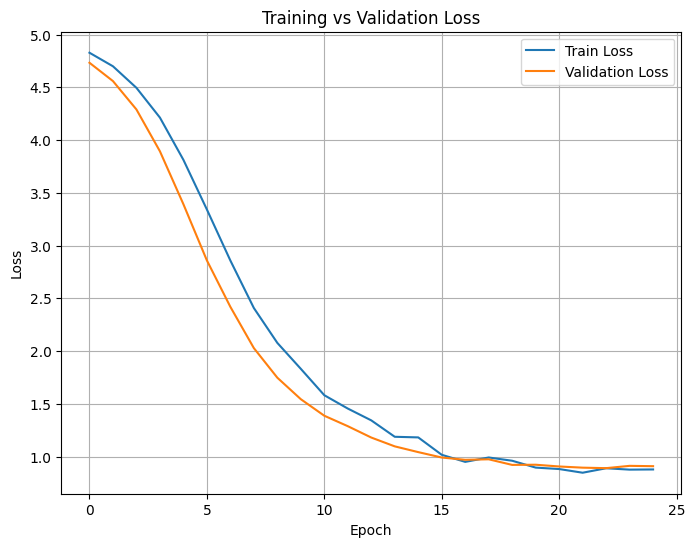

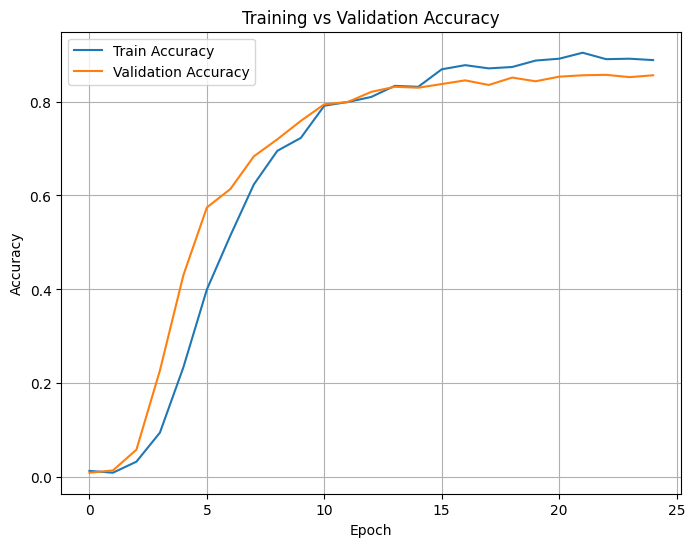

In [ ]:
# Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [ ]:
num_classes = conf_dict["num_classes"]

accuracy = tm.Accuracy(
    task = "multiclass",
    num_classes = num_classes,
).to(device)

precision = tm.Precision(
    task = "multiclass",
    num_classes = num_classes,
    average = "macro"
).to(device)

recall = tm.Recall(
    task = "multiclass",
    num_classes = num_classes,
    average = "macro"
).to(device)

f1 = tm.F1Score(
    task = "multiclass",
    num_classes = num_classes,
    average = "macro"
).to(device)

# conf_mat = tm.ConfusionMatrix(
#     task = "multiclass",
#     num_classes = num_classes,
# ).to(device)

In [ ]:
# Evaluation on Test Data
model.eval()
test_loss = 0.0

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    preds = torch.argmax(outputs, dim=1)
    test_loss += loss.item()

    accuracy(preds, labels)
    precision(preds, labels)
    recall(preds, labels)
    f1(preds, labels)
    # conf_mat(preds, labels)

test_loss /= len(test_loader)

# Compute Metrics
test_accuracy = accuracy.compute().item()
test_precision = precision.compute().item()
test_recall = recall.compute().item()
test_f1 = f1.compute().item()
# test_cm = conf_mat.compute().cpu().numpy()

print(f"Test Loss: {test_loss:.4f} \nAccuracy: {test_accuracy:.4f} \nPrecision: {test_precision:.4f} \nRecall: {test_recall:.4f} \nF1: {test_f1:.4f}")

# Plot Confusion Matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

# Reset Metrics
accuracy.reset()
precision.reset()
recall.reset()
f1.reset()
# conf_mat.reset()

Test Loss: 0.9738 
Accuracy: 0.8278 
Precision: 0.8025 
Recall: 0.8468 
F1: 0.8165


# Partial Fine-Tuning

Unfreeze layers close to the classifer head

## Model Definition

In [ ]:
# Reload pretrained ResNet18
model = tv.models.resnet18(
    weights = tv.models.ResNet18_Weights.DEFAULT
)

# Freeze all model parameters
for params in model.parameters():
  params.requires_grad = False

# Get the number of input features to the final layer
in_features = model.fc.in_features

# Replace the final fc layer to match 102 classes
model.fc = nn.Linear(in_features, 102)

# Unfreeze last block
# For ResNet18, "layer4" is the last residual block
for param in model.layer4.parameters():
    param.requires_grad = True

# Unfreeze only classifier parameters
for params in model.fc.parameters():
  params.requires_grad = True

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model Training

In [ ]:
# Redefine Optimizer
optimizer = torch.optim.Adam([
    {"params": model.layer4.parameters(), "lr": conf_dict["lr_backbone"]},
    {"params": model.fc.parameters(), "lr": conf_dict["lr_head"]}
])

# Redefine Scheduler
steps_per_epoch = math.ceil(len(train_loader))

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr = [conf_dict["lr_backbone"], conf_dict["lr_head"]],
    steps_per_epoch = steps_per_epoch,
    epochs = conf_dict["epochs"]
)

In [ ]:
# Training Loop
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(conf_dict["epochs"]):

  # Training Phase
  model.train()
  epoch_train_loss = 0.0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    epoch_train_loss += loss.item()

    preds = torch.argmax(outputs, dim=1)
    accuracy(preds, labels) # Using torchmetrics.Accuracy() to calculate accuracy

  epoch_train_loss /= len(train_loader)
  epoch_train_acc = accuracy.compute().item()
  accuracy.reset()
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_acc)

  # Validation Phase
  model.eval()
  epoch_val_loss = 0.0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      epoch_val_loss += loss.item()

      preds = torch.argmax(outputs, dim=1)
      accuracy(preds, labels)

  epoch_val_loss /= len(val_loader)
  epoch_val_acc = accuracy.compute().item()
  accuracy.reset()
  val_loss.append(epoch_val_loss)
  val_acc.append(epoch_val_acc)

  print(f"Epoch [{epoch+1}/{conf_dict['epochs']}], "
          f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}"
  )

Epoch [1/25], Train Loss: 4.7939, Acc: 0.0108, Val Loss: 4.6955, Acc: 0.0176
Epoch [2/25], Train Loss: 4.5739, Acc: 0.0275, Val Loss: 4.3819, Acc: 0.0529
Epoch [3/25], Train Loss: 4.1948, Acc: 0.1196, Val Loss: 3.8160, Acc: 0.2892
Epoch [4/25], Train Loss: 3.6015, Acc: 0.3353, Val Loss: 2.8678, Acc: 0.5451
Epoch [5/25], Train Loss: 2.7150, Acc: 0.5784, Val Loss: 1.8794, Acc: 0.7245
Epoch [6/25], Train Loss: 1.9739, Acc: 0.7078, Val Loss: 1.2671, Acc: 0.8020
Epoch [7/25], Train Loss: 1.4380, Acc: 0.7765, Val Loss: 0.9312, Acc: 0.8284
Epoch [8/25], Train Loss: 1.0303, Acc: 0.8314, Val Loss: 0.7333, Acc: 0.8539
Epoch [9/25], Train Loss: 0.7648, Acc: 0.8843, Val Loss: 0.6217, Acc: 0.8725
Epoch [10/25], Train Loss: 0.6467, Acc: 0.9049, Val Loss: 0.5696, Acc: 0.8824
Epoch [11/25], Train Loss: 0.5211, Acc: 0.9206, Val Loss: 0.5036, Acc: 0.8951
Epoch [12/25], Train Loss: 0.4458, Acc: 0.9275, Val Loss: 0.4771, Acc: 0.9029
Epoch [13/25], Train Loss: 0.3834, Acc: 0.9422, Val Loss: 0.4451, Acc: 0.

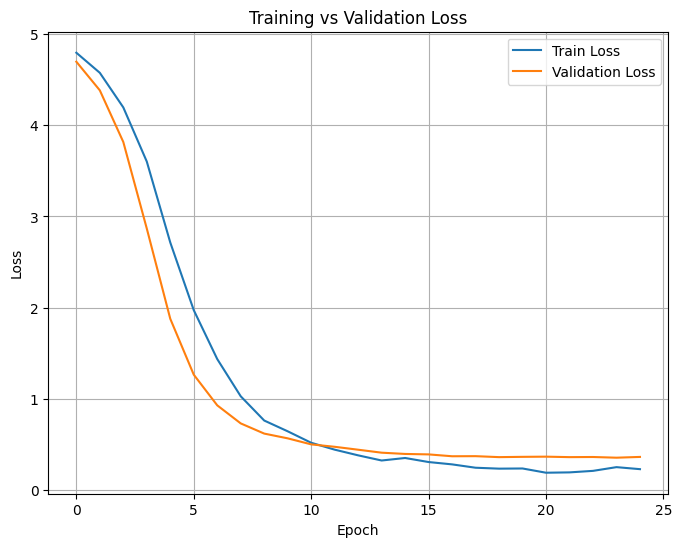

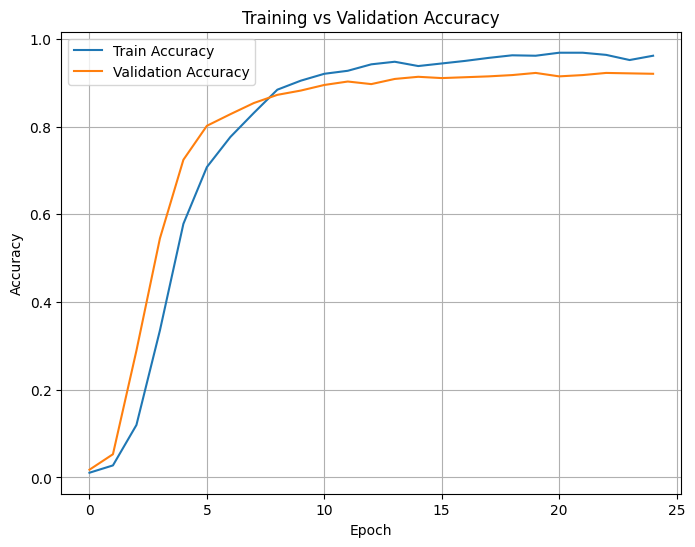

In [ ]:
# Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [ ]:
# Evaluation on Test Data
model.eval()
test_loss = 0.0

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    preds = torch.argmax(outputs, dim=1)
    test_loss += loss.item()

    accuracy(preds, labels)
    precision(preds, labels)
    recall(preds, labels)
    f1(preds, labels)

test_loss /= len(test_loader)

# Compute Metrics
test_accuracy = accuracy.compute().item()
test_precision = precision.compute().item()
test_recall = recall.compute().item()
test_f1 = f1.compute().item()

print(f"Test Loss: {test_loss:.4f} \nAccuracy: {test_accuracy:.4f} \nPrecision: {test_precision:.4f} \nRecall: {test_recall:.4f} \nF1: {test_f1:.4f}")

# Reset Metrics
accuracy.reset()
precision.reset()
recall.reset()
f1.reset()

Test Loss: 0.4127 
Accuracy: 0.9067 
Precision: 0.8944 
Recall: 0.9173 
F1: 0.9018


Partially fine-tuned model (with unfrozen classifier head and unfrozen last residual block) performs better than the previous model.

# Full Fine-tuning

## Model Definition

In [ ]:
# Reload Pretrained ResNet18
model = tv.models.resnet18(
    weights = tv.models.ResNet18_Weights.DEFAULT
)

# Replace the final fc layer to match 102 classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 102)

# Unfreeze All Layers
for param in model.parameters():
  param.requires_grad = True

model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model Training

In [ ]:
# Define AdamW Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = conf_dict["lr_backbone"], # Using "lr_head" because it is the smaller value
    weight_decay = conf_dict["weight_decay"]
)

# Redefine Scheduler
steps_per_epoch = math.ceil(len(train_loader))

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr = conf_dict["lr_head"],
    steps_per_epoch = steps_per_epoch,
    epochs = conf_dict["epochs"]
)

In [ ]:
# Training Loop
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(conf_dict["epochs"]):

  # Training Phase
  model.train()
  epoch_train_loss = 0.0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    epoch_train_loss += loss.item()

    preds = torch.argmax(outputs, dim=1)
    accuracy(preds, labels) # Using torchmetrics.Accuracy() to calculate accuracy

  epoch_train_loss /= len(train_loader)
  epoch_train_acc = accuracy.compute().item()
  accuracy.reset()
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_acc)

  # Validation Phase
  model.eval()
  epoch_val_loss = 0.0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      epoch_val_loss += loss.item()

      preds = torch.argmax(outputs, dim=1)
      accuracy(preds, labels)

  epoch_val_loss /= len(val_loader)
  epoch_val_acc = accuracy.compute().item()
  accuracy.reset()
  val_loss.append(epoch_val_loss)
  val_acc.append(epoch_val_acc)

  print(f"Epoch [{epoch+1}/{conf_dict['epochs']}], "
          f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}"
  )

Epoch [1/25], Train Loss: 4.6021, Acc: 0.0324, Val Loss: 4.0950, Acc: 0.1343
Epoch [2/25], Train Loss: 3.6159, Acc: 0.3255, Val Loss: 2.5562, Acc: 0.5716
Epoch [3/25], Train Loss: 2.3660, Acc: 0.6431, Val Loss: 1.4129, Acc: 0.7167
Epoch [4/25], Train Loss: 1.4981, Acc: 0.7480, Val Loss: 1.1525, Acc: 0.7353
Epoch [5/25], Train Loss: 1.1652, Acc: 0.7725, Val Loss: 1.4044, Acc: 0.6412
Epoch [6/25], Train Loss: 1.1484, Acc: 0.7441, Val Loss: 2.7777, Acc: 0.4176
Epoch [7/25], Train Loss: 1.3430, Acc: 0.6657, Val Loss: 3.3093, Acc: 0.3569
Epoch [8/25], Train Loss: 1.3273, Acc: 0.6794, Val Loss: 2.3508, Acc: 0.4784
Epoch [9/25], Train Loss: 1.2220, Acc: 0.6794, Val Loss: 1.6277, Acc: 0.5922
Epoch [10/25], Train Loss: 0.8367, Acc: 0.7971, Val Loss: 0.9826, Acc: 0.7539
Epoch [11/25], Train Loss: 0.6767, Acc: 0.8373, Val Loss: 0.8086, Acc: 0.7765
Epoch [12/25], Train Loss: 0.5470, Acc: 0.8686, Val Loss: 0.8154, Acc: 0.7863
Epoch [13/25], Train Loss: 0.5593, Acc: 0.8637, Val Loss: 0.8091, Acc: 0.

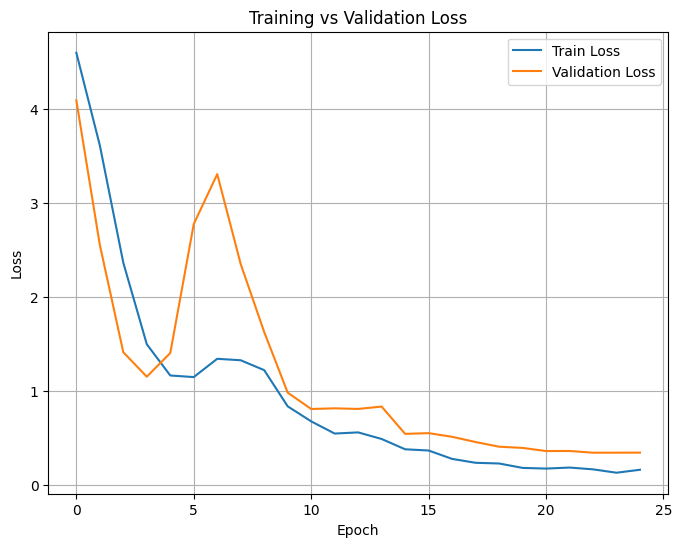

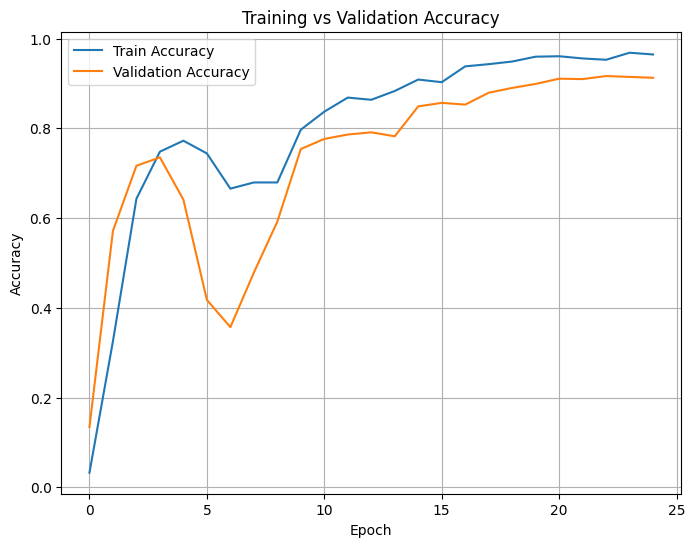

In [ ]:
# Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [ ]:
# Evaluation On Test Data
model.eval()
test_loss = 0.0

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    preds = torch.argmax(outputs, dim=1)
    test_loss = loss.item()

    accuracy(preds, labels)
    precision(preds, labels)
    recall(preds, labels)
    f1(preds, labels)

test_loss /= len(test_loader)

# Compute Metrics
test_acc = accuracy.compute().item()
test_precision = precision.compute().item()
test_recall = recall.compute().item()
test_f1 = f1.compute().item()

print(f"Test Loss: {test_loss:.4f} \nAccuracy: {test_accuracy:.4f} \nPrecision: {test_precision:.4f} \nRecall: {test_recall:.4f} \nF1: {test_f1:.4f}")

# Reset Metrics
accuracy.reset()
precision.reset()
recall.reset()
f1.reset()

Test Loss: 0.0004 
Accuracy: 0.9067 
Precision: 0.8799 
Recall: 0.9113 
F1: 0.8910


# Insights

## Transfer Learning Experiments with ResNet18 on Flowers-102

We experimented with three different fine-tuning strategies for ResNet18 on the Flowers-102 dataset:

---

### 1. Head-Only Training
- **Setup:** Only the final classification head was trained, while the backbone stayed frozen.  
- **Results:**  
  - Test Accuracy: ~82.8%  
  - F1 Score: ~0.82  
- **Takeaway:**  
  Solid baseline — the pretrained backbone already extracts useful features.  
  However, performance plateaued in the low 80s.

---

### 2. Partial Fine-Tuning
- **Setup:** The classification head plus some later layers of the backbone were unfrozen and trained.  
- **Results:**  
  - Test Accuracy: ~90.7%  
  - F1 Score: ~0.90  
- **Takeaway:**  
  Best-performing setup. Later layers adapted to flower-specific features, while earlier layers stayed stable.  
  This gave strong accuracy, high F1, and stable training.

---

### 3. Full Fine-Tuning
- **Setup:** All layers of the ResNet18 backbone were unfrozen and trained.  
- **Results:**  
  - Test Accuracy: ~90.7%  
  - F1 Score: ~0.89  
- **Takeaway:**  
  Similar performance to partial fine-tuning, but training was noisier and riskier.  
  No real gains over partial fine-tuning, just higher instability.

---

### Final Verdict
- **Head-only** = quick baseline, but underfits.  
- **Partial fine-tuning** = **best tradeoff** — strong accuracy, high F1, stable training.  
- **Full fine-tuning** = works, but doesn’t beat partial fine-tuning and is less stable.  

-> In practice, **partial fine-tuning is the sweet spot** for Flowers-102 with ResNet18.